<h2><b>Generate mood labels for the main dataset</b></h2>

<h4>Import necessary libraries</h4>

In [1]:
import sklearn
import pandas as pd
from numpy import mean
from numpy import std
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plt

<h3>Load Labelled data</h3>

In [2]:
data = pd.read_csv('data_moods.csv')
data.columns

Index(['name', 'album', 'artist', 'id', 'release_date', 'popularity', 'length',
       'danceability', 'acousticness', 'energy', 'instrumentalness',
       'liveness', 'valence', 'loudness', 'speechiness', 'tempo', 'key',
       'time_signature', 'mood'],
      dtype='object')

In [3]:
X = data.select_dtypes('number')
y = data['mood']

<h3>Select Number of features</h3>

In [4]:
def gen_models(model_name):
	"""
	input: a model name
	output: a dictionary of models with number of features in range [5,9]
	"""
	models = dict()
	for i in range(2, 10):
		rfe = RFE(estimator=model_name(), n_features_to_select=i)
		model = DecisionTreeClassifier()
		models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
	return models



def evaluate_model(model, X, y):
    """
    Runs 3 fold cross validation using provided model, X and y
    Returns scores
    """
    cross_validation = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cross_validation, n_jobs=-1, error_score='raise')
    return scores



def plot_model_comparisons(model_names):
    """
    input: array of model names as defined in sklearn library
    output: plots a 2X2 grid of plots, so input array length is expected to be 4
    """
    assert(len(model_names) == 4)
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    axs = axs.flatten()

    for i, ax in enumerate(axs):
        model_name = model_names[i]
        models = gen_models(model_name)
        results, names = [], []
        for name, model in models.items():
            scores = evaluate_model(model, X, y)
            results.append(scores)
            names.append(name)
            print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
        
        ax.boxplot(results, labels=names, showmeans=True)
        ax.set_title(str(model_name).split('.')[-1])

    plt.tight_layout()
    plt.show()

>2 0.720 (0.057)
>3 0.729 (0.045)
>4 0.721 (0.041)
>5 0.729 (0.047)
>6 0.734 (0.044)
>7 0.734 (0.046)
>8 0.739 (0.040)
>9 0.745 (0.029)


/Users/washikuddinahmedmollah/Documents/CS470_IntroToAi/project2/cs470_introAi_final_project_music_recommendation/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/washikuddinahmedmollah/Documents/CS470_IntroToAi/project2/cs470_introAi_final_project_music_recommendation/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://sci

>2 0.720 (0.056)


/Users/washikuddinahmedmollah/Documents/CS470_IntroToAi/project2/cs470_introAi_final_project_music_recommendation/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/washikuddinahmedmollah/Documents/CS470_IntroToAi/project2/cs470_introAi_final_project_music_recommendation/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://sci

>3 0.717 (0.049)


/Users/washikuddinahmedmollah/Documents/CS470_IntroToAi/project2/cs470_introAi_final_project_music_recommendation/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/washikuddinahmedmollah/Documents/CS470_IntroToAi/project2/cs470_introAi_final_project_music_recommendation/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://sci

>4 0.742 (0.042)


/Users/washikuddinahmedmollah/Documents/CS470_IntroToAi/project2/cs470_introAi_final_project_music_recommendation/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/washikuddinahmedmollah/Documents/CS470_IntroToAi/project2/cs470_introAi_final_project_music_recommendation/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://sci

>5 0.728 (0.048)


/Users/washikuddinahmedmollah/Documents/CS470_IntroToAi/project2/cs470_introAi_final_project_music_recommendation/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/washikuddinahmedmollah/Documents/CS470_IntroToAi/project2/cs470_introAi_final_project_music_recommendation/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://sci

>6 0.731 (0.048)


/Users/washikuddinahmedmollah/Documents/CS470_IntroToAi/project2/cs470_introAi_final_project_music_recommendation/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/washikuddinahmedmollah/Documents/CS470_IntroToAi/project2/cs470_introAi_final_project_music_recommendation/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://sci

>7 0.721 (0.045)


/Users/washikuddinahmedmollah/Documents/CS470_IntroToAi/project2/cs470_introAi_final_project_music_recommendation/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/washikuddinahmedmollah/Documents/CS470_IntroToAi/project2/cs470_introAi_final_project_music_recommendation/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://sci

>8 0.723 (0.047)


/Users/washikuddinahmedmollah/Documents/CS470_IntroToAi/project2/cs470_introAi_final_project_music_recommendation/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/washikuddinahmedmollah/Documents/CS470_IntroToAi/project2/cs470_introAi_final_project_music_recommendation/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://sci

>9 0.737 (0.037)
>2 0.386 (0.084)
>3 0.567 (0.075)
>4 0.634 (0.049)
>5 0.640 (0.048)
>6 0.648 (0.051)
>7 0.704 (0.058)
>8 0.723 (0.033)
>9 0.735 (0.033)
>2 0.718 (0.053)
>3 0.737 (0.043)
>4 0.732 (0.049)
>5 0.737 (0.039)
>6 0.726 (0.040)
>7 0.730 (0.039)
>8 0.756 (0.041)
>9 0.749 (0.030)


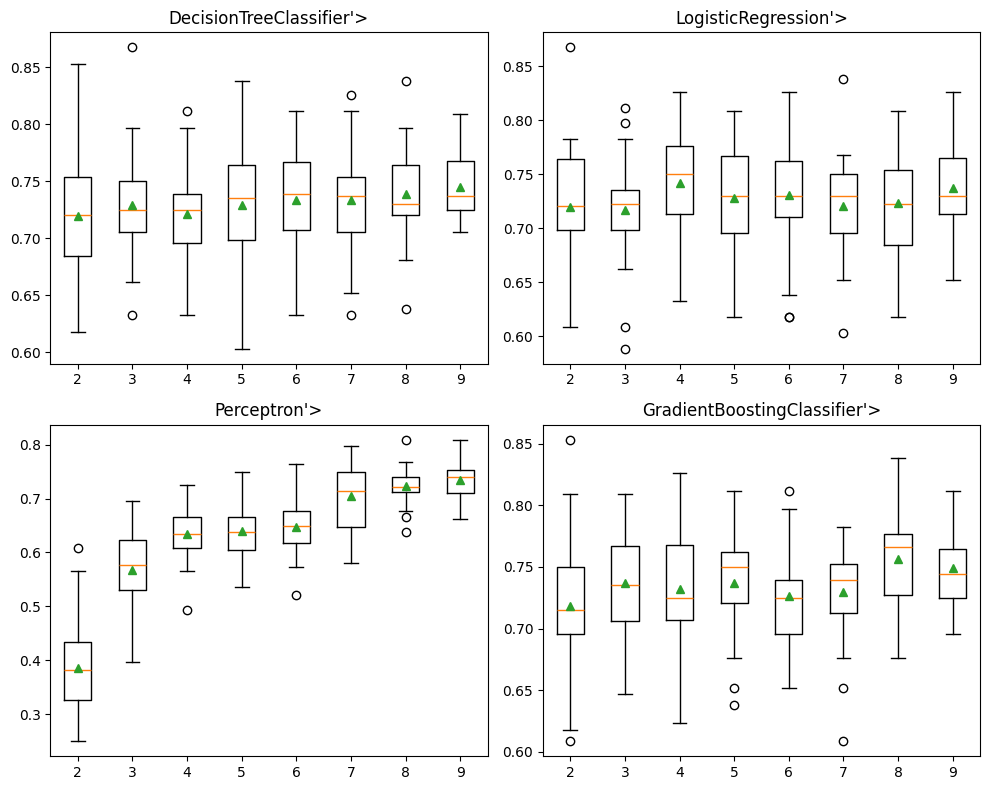

In [5]:
model_names = [DecisionTreeClassifier, LogisticRegression, Perceptron, GradientBoostingClassifier]
plot_model_comparisons(model_names=model_names)